In [41]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer
import ELPH_Dim_Reducer
import ELPH_VAR_Transformer

from ELPH_RDNLVAR import RDNLVAR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
runs = ELPH_utils.load_runs(filename='../runs_rand_inits.npz')
# runs = ELPH_utils.load_runs(filename='../runs.npz')

# runs = runs[:100:1]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

500 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


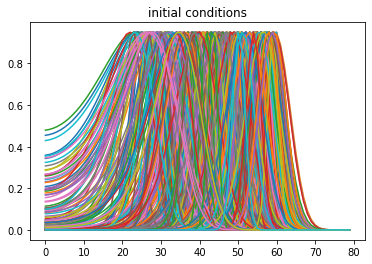

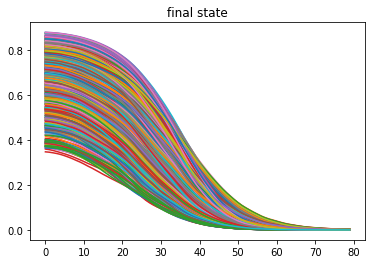

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

rdim:  20
prdim:  20
n_VAR_steps:  2
train shape:  (541, 199500)
target shape:  (20, 199500)
weights shape:  (541, 20)


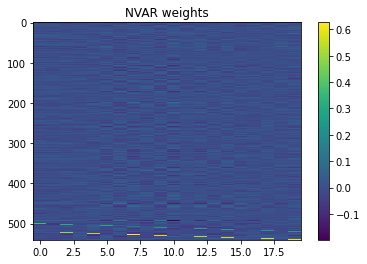

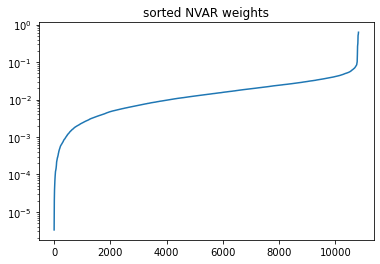

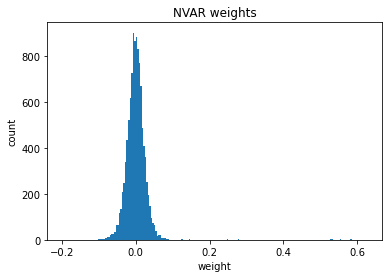

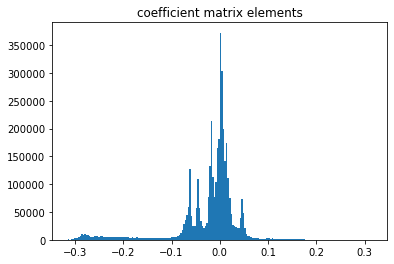

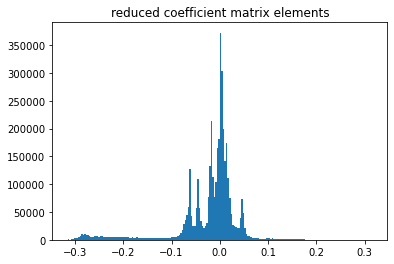

In [59]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)
scaler = ELPH_Scaler.normalize_scaler(0.63)
dim_reducer = ELPH_Dim_Reducer.SVD()

def sigmoid(x):
    return 2.0/(1.0 + np.exp(-x)) -1.0

activation_function=np.tanh

ELM_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=500, activation_function=activation_function)

model = RDNLVAR(runs)
model.train(rdim=20, prdim = 20, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=ELM_transformer)
model.print_status()

plt.imshow(model.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(model.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(model.w), bins=200)
plt.title('NVAR weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

plt.hist(np.ravel(model.coef_matrix), bins=200)
plt.title('coefficient matrix elements')
plt.show()

plt.hist(np.ravel(model.coef_matrix[:model.rdim]), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

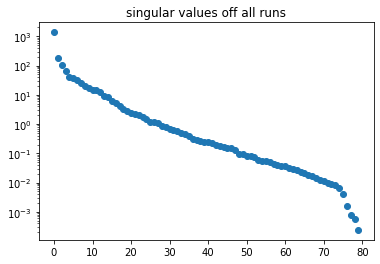

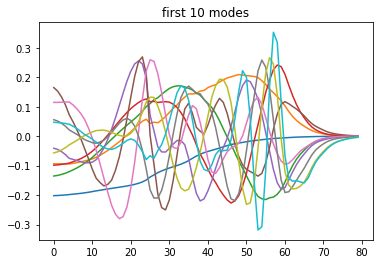

In [6]:
plt.semilogy(dim_reducer.S, 'o')
plt.title('singular values off all runs')
plt.show()

rdim = 10
for l in range(rdim):
  plt.plot(dim_reducer.U[:,l],  label='U_'+str(l))
plt.title('first ' + str(rdim) + ' modes')
plt.show()

In [55]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)
scaler = ELPH_Scaler.normalize_scaler(0.63)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=500, activation_function=activation_function, seed=0)

train_kwargs = {'rdim':20, 'prdim':40, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
score_kwargs = {'norm':'std'}


m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.002265417990964163
0.00025160293322346023
[0.001777147134121282, 0.0024779044918072945, 0.0024175757544535595, 0.0022943110413769256, 0.0023601515330617536]


rdim:  20
prdim:  30
n_VAR_steps:  2
train shape:  (541, 199101)
target shape:  (30, 199101)
weights shape:  (541, 30)
error:  0.06990513839355794


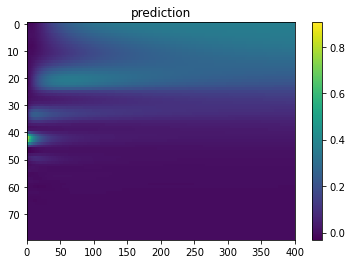

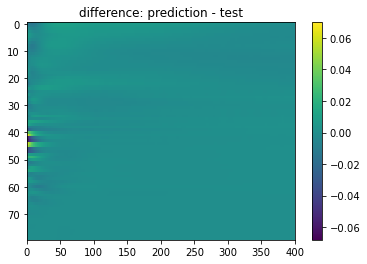

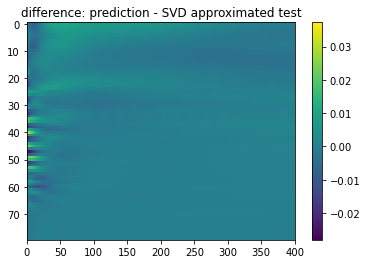

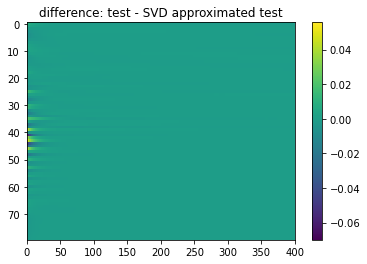

In [56]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)
scaler = ELPH_Scaler.normalize_scaler(0.63)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=500, activation_function=activation_function, seed=0)

train_runs = runs[::1]
test_run = train_runs.pop(85)

model.load_runs(train_runs)
model.train(rdim=20, prdim = 30, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=VAR_transformer)

model.print_status()


print('error: ', model.get_error(test_run, norm='max') )

pred = model.predict_single_run(test_run)

xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()


test_run_SVDapprx = dim_reducer.U[:,:30] @ dim_reducer.U[:,:30].T @ test_run

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()


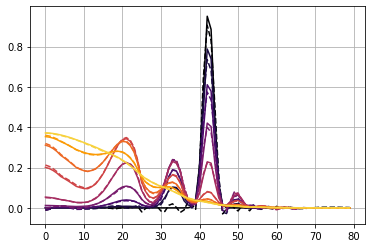

std error:  0.0031291288342334064
max abs error:  0.06990513839355794


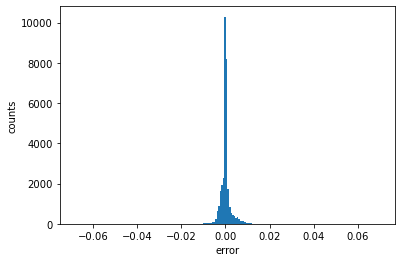

In [57]:
colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))

plt.show()

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max abs error: ', model.get_error(test_run, pred, norm='max') )

plt.hist(np.ravel(pred-test_run), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()